# Work here

In [1]:

import pickle
import random
import numpy as np

import theano
import theano.tensor as T
import lasagne

from collections import Counter
from lasagne.utils import floatX

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 4007)


Download the data set

In [2]:
#!wget https://s3.amazonaws.com/lasagne/recipes/datasets/coco_with_cnn_features.pkl

Load the dataset

In [3]:
from sklearn.cross_validation import train_test_split

dataset = pickle.load(open('coco_with_cnn_features.pkl')) #This is a list of dictionaries
#Split into training (60%), validation (20%) and test (20%)
#dataset, dataset_test = train_test_split(dataset,test_size=0.4)
#dataset_test, dataset_valid = train_test_split(dataset_test,test_size=0.5)
#print len(dataset), len(dataset_test), len(dataset_valid)
#X = get_my_X()
#y = get_my_y()
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [4]:
yo = [x['split'] for x in dataset]
print 'Number of test', sum(x=='test' for x in yo)
print 'Number of val', sum(x=='val' for x in yo)
print 'Number of restval', sum(x=='restval' for x in yo)
print 'Number of train', sum(x=='train' for x in yo)

Number of test 5000
Number of val 5000
Number of restval 30504
Number of train 82783


In [5]:
allwords = Counter()
for item in dataset:
    for sentence in item['sentences']:
        allwords.update(sentence['tokens'])
        
vocab = [k for k, v in allwords.items() if v >= 5] #Finding words that occure more than 5 times
vocab.insert(0, '#START#')
vocab.append('#END#')

word_to_index = {w: i for i, w in enumerate(vocab)} #Dic with word as key and index as value
index_to_word = {i: w for i, w in enumerate(vocab)} #Dic with index as key and word as value

In [6]:
SEQUENCE_LENGTH = 32
MAX_SENTENCE_LENGTH = SEQUENCE_LENGTH - 3 # 1 for image, 1 for start token, 1 for end token (This means that we can at most have a caption of length 29 + start and end token)
BATCH_SIZE = 100
CNN_FEATURE_SIZE = 1000
EMBEDDING_SIZE = 512

In [7]:
# Returns a list of tuples (cnn features, list of words, image ID)
def get_data_batch(dataset, size, split='train'): #dataset, size=batch_size(100)
    items = []
    
    while len(items) < size:
        item = random.choice(dataset) #While data less than batch_size, choose a random datapoint
        if item['split'] != split: 
            continue
        sentence = random.choice(item['sentences'])['tokens'] #Choose a random caption from the data point
        if len(sentence) > MAX_SENTENCE_LENGTH: #Check that that caption is not longer than max sentence length
            continue
        items.append((item['cnn features'], sentence, item['cocoid'])) #Add the cnn features, sentence and id to the batch
    
    return items #Returns the batch which is a list consisting of tuples (it should be the same length as size?)

In [8]:
# Convert a list of tuples into arrays that can be fed into the network
def prep_batch_for_network(batch):
    x_cnn = floatX(np.zeros((len(batch), 1000))) #batch_size X 1000 (1000 is the number of cnn features)
    x_sentence = np.zeros((len(batch), SEQUENCE_LENGTH - 1), dtype='int32') #batch_size x 31 (which is  the max length of a sentence if we include start and stop characters)
    y_sentence = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='int32') #Why is this one longer?
    mask = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='bool') #What is mask?

    for j, (cnn_features, sentence, _) in enumerate(batch):
        x_cnn[j] = cnn_features
        i = 0
        for word in ['#START#'] + sentence + ['#END#']:
            if word in word_to_index:
                mask[j, i] = True
                y_sentence[j, i] = word_to_index[word]
                x_sentence[j, i] = word_to_index[word]
                i += 1
        mask[j, 0] = False
                
    return x_cnn, x_sentence, y_sentence, mask

In [9]:
# sentence embedding maps integer sequence with dim (BATCH_SIZE, SEQUENCE_LENGTH - 1) to 
# (BATCH_SIZE, SEQUENCE_LENGTH-1, EMBEDDING_SIZE)

### ENCODER STARTS ###
## Enocding the captions
l_input_sentence = lasagne.layers.InputLayer((BATCH_SIZE, SEQUENCE_LENGTH - 1)) #Batch size time the length of the caption
l_sentence_embedding = lasagne.layers.EmbeddingLayer(l_input_sentence,
                                                     input_size=len(vocab),
                                                     output_size=EMBEDDING_SIZE,
                                                    )

# cnn embedding changes the dimensionality of the representation from 1000 to EMBEDDING_SIZE, 
# and reshapes to add the time dimension - final dim (BATCH_SIZE, 1, EMBEDDING_SIZE)
l_input_cnn = lasagne.layers.InputLayer((BATCH_SIZE, CNN_FEATURE_SIZE)) #Batch size times 100
l_cnn_embedding = lasagne.layers.DenseLayer(l_input_cnn, num_units=EMBEDDING_SIZE,
                                            nonlinearity=lasagne.nonlinearities.identity) #Resize the cnn to embdding_size (512 i belive)

l_cnn_embedding = lasagne.layers.ReshapeLayer(l_cnn_embedding, ([0], 1, [1])) #Reshape the embedding to ...

# the two are concatenated to form the RNN input with dim (BATCH_SIZE, SEQUENCE_LENGTH, EMBEDDING_SIZE)
### DECODER STARTS##

l_rnn_input = lasagne.layers.ConcatLayer([l_cnn_embedding, l_sentence_embedding]) 

l_dropout_input = lasagne.layers.DropoutLayer(l_rnn_input, p=0.5)
l_lstm = lasagne.layers.LSTMLayer(l_dropout_input,
                                  num_units=EMBEDDING_SIZE,
                                  unroll_scan=True,
                                  grad_clipping=5.)
l_dropout_output = lasagne.layers.DropoutLayer(l_lstm, p=0.5)

# the RNN output is reshaped to combine the batch and time dimensions
# dim (BATCH_SIZE * SEQUENCE_LENGTH, EMBEDDING_SIZE)
l_shp = lasagne.layers.ReshapeLayer(l_dropout_output, (-1, EMBEDDING_SIZE))

# decoder is a fully connected layer with one output unit for each word in the vocabulary
l_decoder = lasagne.layers.DenseLayer(l_shp, num_units=len(vocab), nonlinearity=lasagne.nonlinearities.softmax)

# finally, the separation between batch and time dimension is restored
l_out = lasagne.layers.ReshapeLayer(l_decoder, (BATCH_SIZE, SEQUENCE_LENGTH, len(vocab)))

In [10]:
# cnn feature vector
x_cnn_sym = T.matrix()

# sentence encoded as sequence of integer word tokens
x_sentence_sym = T.imatrix()

# mask defines which elements of the sequence should be predicted
mask_sym = T.imatrix()

# ground truth for the RNN output
y_sentence_sym = T.imatrix()

In [11]:
output = lasagne.layers.get_output(l_out, {
                l_input_sentence: x_sentence_sym,
                l_input_cnn: x_cnn_sym
                })

/usr/local/lib/python2.7/dist-packages/lasagne/layers/recurrent.py:1089: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.
  n_steps=input_shape[1])
/usr/local/lib/python2.7/dist-packages/lasagne/layers/recurrent.py:1089: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.
  n_steps=input_shape[1])


In [12]:
def calc_cross_ent(net_output, mask, targets):
    # Helper function to calculate the cross entropy error
    preds = T.reshape(net_output, (-1, len(vocab)))
    targets = T.flatten(targets)
    cost = T.nnet.categorical_crossentropy(preds, targets)[T.flatten(mask).nonzero()]
    return cost

loss = T.mean(calc_cross_ent(output, mask_sym, y_sentence_sym))

In [13]:
MAX_GRAD_NORM = 15

all_params = lasagne.layers.get_all_params(l_out, trainable=True)

all_grads = T.grad(loss, all_params)
all_grads = [T.clip(g, -5, 5) for g in all_grads]
all_grads, norm = lasagne.updates.total_norm_constraint(
    all_grads, MAX_GRAD_NORM, return_norm=True)

updates = lasagne.updates.adam(all_grads, all_params, learning_rate=0.001)

f_train = theano.function([x_cnn_sym, x_sentence_sym, mask_sym, y_sentence_sym],
                          [loss, norm, output],
                          updates=updates
                         )

f_val = theano.function([x_cnn_sym, x_sentence_sym, mask_sym, y_sentence_sym], [loss,output])

f_eval = theano.function([x_sentence_sym,x_cnn_sym], output, on_unused_input='warn')

In [14]:
#myLayers = lasagne.layers.get_all_param_values(l_out)
#with open('3000Layers','w') as f:
#    pickle.dump(myLayers,f)
layers3000 = pickle.load(open('3000Layers', 'rb'))
lasagne.layers.set_all_param_values(l_out, layers3000)

In [ ]:
for iteration in range(3000):
    x_cnn, x_sentence, y_sentence, mask = prep_batch_for_network(get_data_batch(dataset, BATCH_SIZE))
    loss_train, norm,output = f_train(x_cnn, x_sentence, mask, y_sentence)
    if not iteration % 250:
        print('Iteration {}, loss_train: {}, norm: {}'.format(iteration, loss_train, norm))
        try:
            batch = get_data_batch(dataset, BATCH_SIZE, split='val')
            x_cnn, x_sentence, y_sentence, mask = prep_batch_for_network(batch)
            loss_val,output_val = f_val(x_cnn, x_sentence, mask, y_sentence)
            print('Val loss: {}'.format(loss_val))
            image_nr = 1
            print [index_to_word[x] for x in x_sentence[image_nr]]
            print [index_to_word[np.argmax(x)] for x in output_val[image_nr]]
        except IndexError:
            continue    

In [15]:
import matplotlib.pyplot as plt
import skimage.io as io
def imgPlotter(fileName):
    if fileName[0:10]=='COCO_train':
        fileDir = "../coco/train2014"
    if fileName[0:8]=='COCO_val' or fileName[0:9]=='COCO_test':
        fileDir = "../coco/val2014"
    img = io.imread('%s/%s'%(fileDir,fileName))
    plt.imshow(img)
    plt.show()

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [ ]:
#myInputBatch = get_data_batch(dataset, BATCH_SIZE, split='test')
#print myInputBatch[1][1]
#print myInputBatch[1][2]
#theOne = [x for x in dataset if x['cocoid']==myInputBatch[99][2]]
#x_cnn, x_sentence, y_sentence, mask = prep_batch_for_network(myInputBatch)
#x_cnn.shape
#f_eval(np.zeros((BATCH_SIZE, SEQUENCE_LENGTH - 1), dtype='int32'), x_cnn).shape

In [16]:
def predict(x_cnn):
    wordsList = ['']*BATCH_SIZE
    x_sentence = np.zeros((BATCH_SIZE, SEQUENCE_LENGTH - 1), dtype='int32')
    continueBool = [True]*BATCH_SIZE
    i = 0
    words = [[]]*BATCH_SIZE
    while any(continueBool):
        i += 1
        p0 = f_eval(x_sentence, x_cnn)
        pa = p0.argmax(-1)
        for j in range(BATCH_SIZE):
            if continueBool[j]:
                tok = pa[j,:][i]
                word = index_to_word[tok]
                if word == '#END#' or i >= SEQUENCE_LENGTH - 1:
                    wordsList[j] = (' '.join(words[j]))
                    continueBool[j]=False
                else:
                    x_sentence[j][i] = tok
                    if word != '#START#':
                        words[j] = words[j]+[word]
    return wordsList

In [19]:
dataBatchTest = []
continueBool = True
for i in range(len(dataset)):
    x = dataset[i]
    if continueBool and x['split']=='restval' and max([len(y['tokens']) for y in x['sentences']])<=MAX_SENTENCE_LENGTH:
        for j in range(len(x['sentences'])):
            if len(x['sentences'][j]['tokens'])<=MAX_SENTENCE_LENGTH:
                sentence = x['sentences'][j]['tokens']
        dataBatchTest.append((x['cnn features'], sentence, x['cocoid']))
#dataBatchTest = dataBatchTest[0:(len(dataBatchTest)-(len(dataBatchTest)%100))]
print(len(dataBatchTest))

30385


In [20]:
allTestPreds = []
for i in range(len(dataBatchTest)/BATCH_SIZE):#(len(dataBatchTest)/BATCH_SIZE):
    print (i/float(len(dataBatchTest)/BATCH_SIZE)*100)
    littleDataBatchTest = dataBatchTest[(i*BATCH_SIZE):((i+1)*BATCH_SIZE)]
    imgIds = [x[2] for x in littleDataBatchTest]
    x_cnn, null1, null2, null3 = prep_batch_for_network(littleDataBatchTest)#np.zeros((BATCH_SIZE,1000))
    for j in range(BATCH_SIZE):
        x_cnn[j,] = littleDataBatchTest[j][0]
    sentences = predict(x_cnn)
    for j in range(BATCH_SIZE):
        allTestPreds.append({'image_id':imgIds[j] , 'caption':sentences[j]})

0.0
0.3300330033
0.660066006601
0.990099009901
1.3201320132
1.6501650165
1.9801980198
2.3102310231
2.6402640264
2.9702970297
3.300330033
3.6303630363
3.9603960396
4.2904290429
4.6204620462
4.9504950495
5.28052805281
5.61056105611
5.94059405941
6.27062706271
6.60066006601
6.93069306931
7.26072607261
7.59075907591
7.92079207921
8.25082508251
8.58085808581
8.91089108911
9.24092409241
9.57095709571
9.90099009901
10.2310231023
10.5610561056
10.8910891089
11.2211221122
11.5511551155
11.8811881188
12.2112211221
12.5412541254
12.8712871287
13.201320132
13.5313531353
13.8613861386
14.1914191419
14.5214521452
14.8514851485
15.1815181518
15.5115511551
15.8415841584
16.1716171617
16.501650165
16.8316831683
17.1617161716
17.4917491749
17.8217821782
18.1518151815
18.4818481848
18.8118811881
19.1419141914
19.4719471947
19.801980198
20.1320132013
20.4620462046
20.7920792079
21.1221122112
21.4521452145
21.7821782178
22.1122112211
22.4422442244
22.7722772277
23.102310231
23.4323432343
23.7623762376
24.0

a motorcycle parked on a street next to a street
{'image_id': 271177, 'caption': u'a motorcycle parked on a street next to a street'}


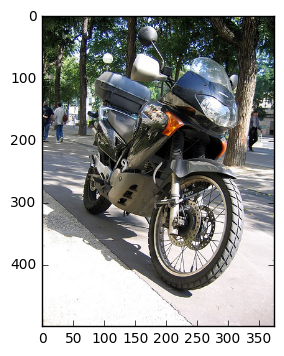

a bathroom with a white toilet and a toilet
{'image_id': 75051, 'caption': u'a bathroom with a white toilet and a toilet'}


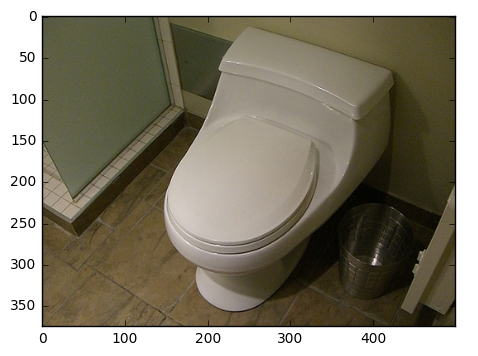

a man riding a motorcycle on a street
{'image_id': 549399, 'caption': u'a man riding a motorcycle on a street'}


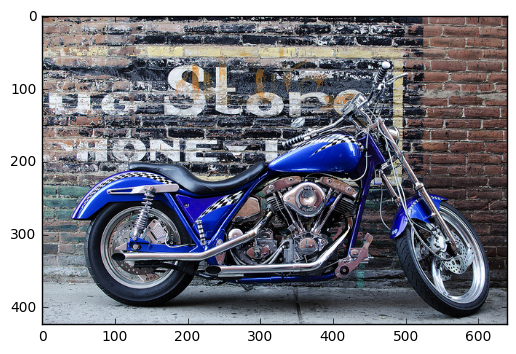

a man sitting on a bed with a laptop
{'image_id': 85160, 'caption': u'a man sitting on a bed with a laptop'}


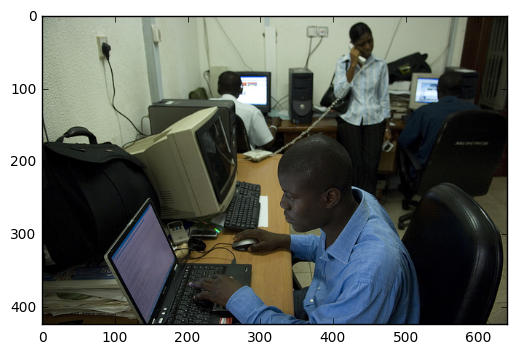

a man riding a motorcycle on a city street
{'image_id': 296649, 'caption': u'a man riding a motorcycle on a city street'}


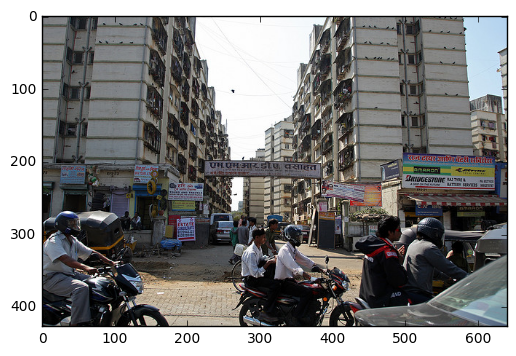

a plate of food with a sandwich and a cup of coffee
{'image_id': 19358, 'caption': u'a plate of food with a sandwich and a cup of coffee'}


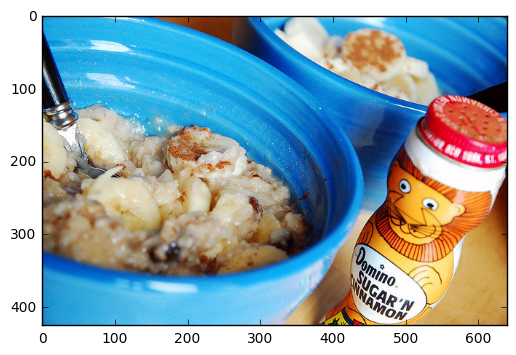

a man is riding a motorcycle on a street
{'image_id': 459912, 'caption': u'a man is riding a motorcycle on a street'}


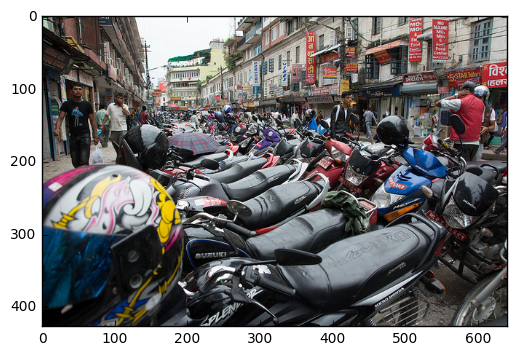

a motorcycle is parked in the middle of a road
{'image_id': 15827, 'caption': u'a motorcycle is parked in the middle of a road'}


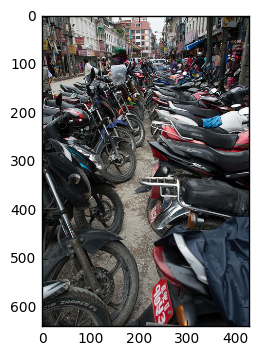

a man riding a motorcycle on a road
{'image_id': 510755, 'caption': u'a man riding a motorcycle on a road'}


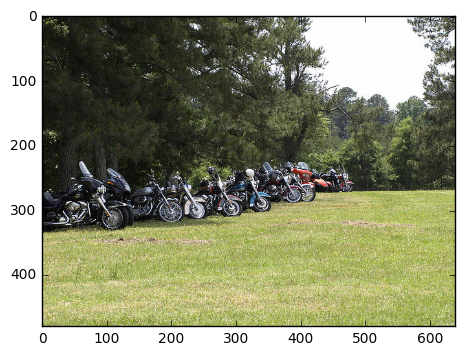

a group of people standing on a street in front of a building
{'image_id': 175831, 'caption': u'a group of people standing on a street in front of a building'}


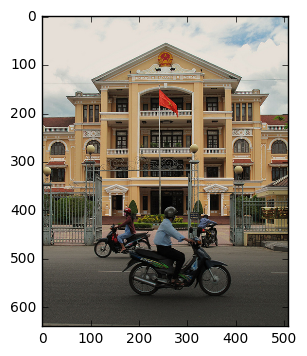

a laptop sitting on a desk with a laptop
{'image_id': 79472, 'caption': u'a laptop sitting on a desk with a laptop'}


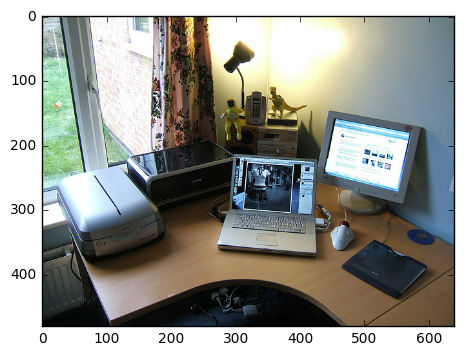

a clock tower with a clock on it
{'image_id': 502136, 'caption': u'a clock tower with a clock on it'}


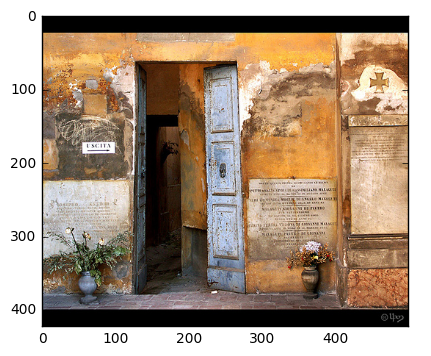

a laptop computer sitting on a desk with a laptop
{'image_id': 250108, 'caption': u'a laptop computer sitting on a desk with a laptop'}


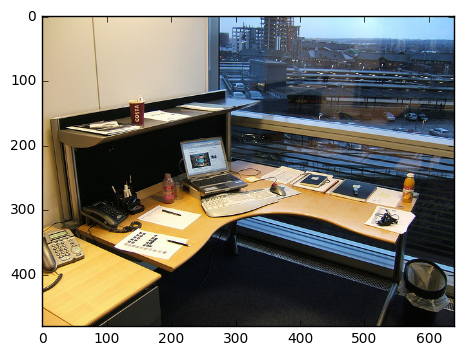

a group of people standing around a bus on a city street
{'image_id': 315601, 'caption': u'a group of people standing around a bus on a city street'}


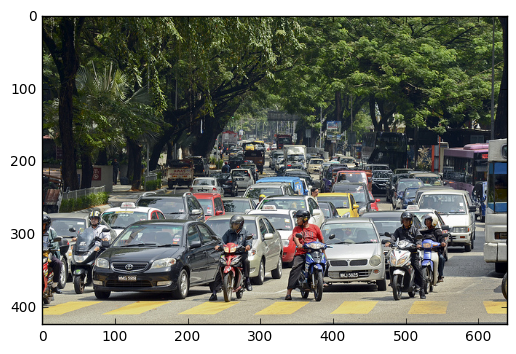

a living room with a couch and a bed
{'image_id': 437218, 'caption': u'a living room with a couch and a bed'}


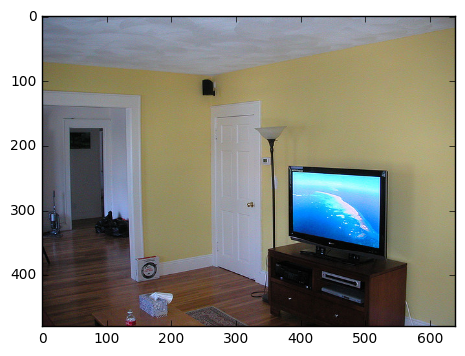

a man riding a skateboard down a street
{'image_id': 503707, 'caption': u'a man riding a skateboard down a street'}


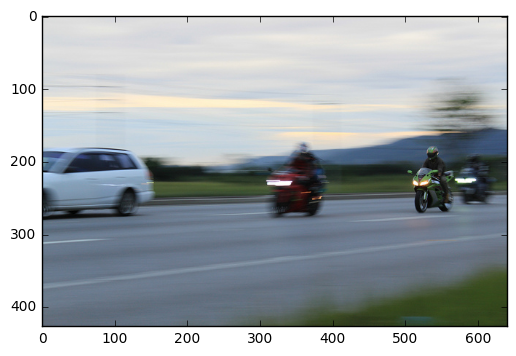

a man riding a bike on a street next to a building
{'image_id': 369763, 'caption': u'a man riding a bike on a street next to a building'}


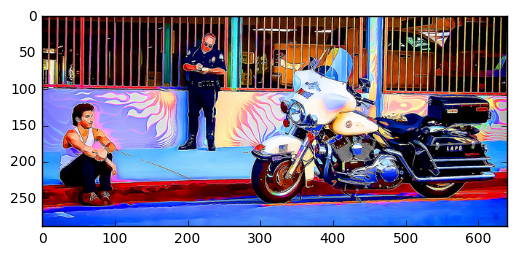

a group of people riding a snow board
{'image_id': 199951, 'caption': u'a group of people riding a snow board'}


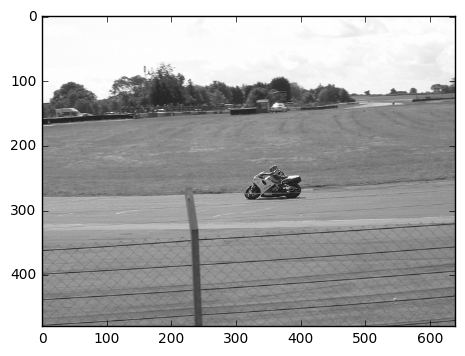

a man holding a hot dog in a hand
{'image_id': 452684, 'caption': u'a man holding a hot dog in a hand'}


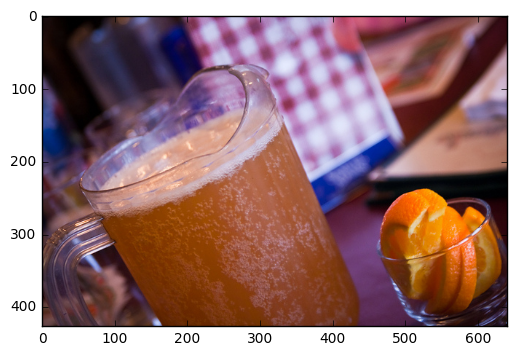

a group of people standing on a street next to a truck
{'image_id': 213687, 'caption': u'a group of people standing on a street next to a truck'}


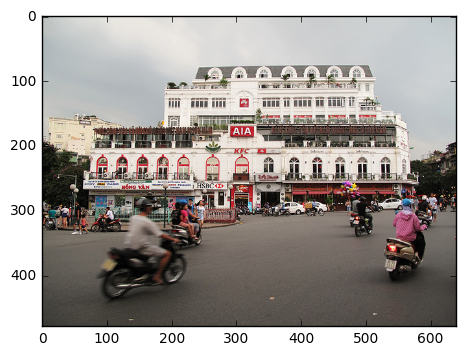

In [21]:
for j in range(80,100):
    print(allTestPreds[j]['caption'])
    print allTestPreds[j]
    try:
        imgPlotter([x['filename'] for x in dataset if x['cocoid']==allTestPreds[j]['image_id']][0])
    except:
        pass

In [22]:
import json
with open('coco-caption/results/captions_val2014_3000restval_results.json', 'w') as outfile:
    json.dump(allTestPreds, outfile)
with open('coco-caption/results/captions_val2014_3000restval_results.json') as json_data:
    d = json.load(json_data)
    print(len(d))

30300
